In [3]:
from google.colab import files         ####Instructions to load data directly from kaggle and download it on colab
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

import zipfile
!unzip /content/chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [1]:
import os                                    
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
def one_hot_encoding(index):                #### one_hot encoding function that takes an index and return an array wit 1 at that index and zeros at the rest
    encoded_arr=[]
    for i in range(0,2):
        if i==index:
            encoded_arr.append(1)
        else:
            encoded_arr.append(0)
    return  encoded_arr

def read_images(path,folder_type):         ## read_images function
    x_train = []
    y_train=[]

    folder_index=0
    for folder in os.listdir(path):                  ####looping on folders (normal,pneumonie)
        folder_path=os.path.join(path,folder)        
        for image in tqdm(os.listdir(folder_path)):   ##looping on images of each folder
            image_path = os.path.join(folder_path,image)    
            #print(image)
            img = cv2.imread(image_path)            
    
            #img=cv2.normalize(img,None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
            
       
            img = cv2.resize(img, (224, 224))    ## resizeing the image to (224,224)
       
            if folder_type==1 and folder=="NORMAL":  #duplicating each normal image 3 times to make them roughly equal the pneumonia images in order to balance the classes (oversampling techinque)
              for i in range(0,3):
                x_train.append(np.array(img))
                y_train.append(np.array(one_hot_encoding(folder_index)))
            else:
              x_train.append(np.array(img))
              y_train.append(np.array(one_hot_encoding(folder_index)))
        folder_index=folder_index+1
   
    x_train, y_train = shuffle(x_train, y_train)     ## shuffling the training data 
    return x_train,y_train

X_train,Y_train=read_images('/content/chest_xray/train',1)      #reading training images
X_val,Y_val=read_images('/content/chest_xray/val',0)         #reading validation images
X_test,Y_test=read_images('/content/chest_xray/test',0)     #reading testing images

mean = np.mean(X_train, keepdims=True )         #standardizing the training ,validation ,testing data according to the training data mean and training data standard diviation
std = np.std(X_train,  keepdims=True)
X_train = (X_train - mean) / std
X_val=(X_val-mean)/std;
X_test=(X_test-mean)/std;

print(np.shape(X_train))

100%|██████████| 234/234 [00:05<00:00, 43.67it/s]


(7898, 224, 224, 3)


In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,InputLayer
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras
import tensorflow as tf

In [4]:
VGGModel=VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))  ## loading vgg19 model pre-trained on image-net dataset without the fully connected layers


#VGGModel.layers[0].trainable=False
#VGGModel.layers[1].trainable=False
#VGGModel.layers[2].trainable=False

x=VGGModel.layers[-1].output   #vector containing the features that will be the input of the fully connected layers

x=keras.layers.Flatten()(x)    #flattening the vector 

x=Dense(1024,activation='relu')(x)      ## adding my own fully connected layers and their dropouts
x=Dropout(0.5)(x)

x=Dense(512,activation='relu')(x)
x=Dropout(0.5)(x)

x=Dense(256,activation='relu')(x)
x=Dropout(0.5)(x)

out=Dense(2,activation='sigmoid')(x)   ##adding the last sigmoid layer
model=Model(VGGModel.input,out)

#op=keras.optimizers.RMSprop(lr=0.0001)
op=keras.optimizers.Adam(lr=0.000001)


model.compile(loss='binary_crossentropy',optimizer=op,metrics=['accuracy'])   ##binary-crossentropy as we only have here two cases for classification (normal , pneumonia)

model.summary()  

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [5]:
X_train=np.array(X_train)    ##converting each list to a numpy array
Y_train=np.array(Y_train)

X_val=np.array(X_val)
Y_val=np.array(Y_val)

X_test=np.array(X_test)
Y_test=np.array(Y_test)

Validation_X=[]           
Validation_X.extend(X_val)
Validation_X.extend(X_test)   ##adding the test data to the validation data as the validation data is to small (well not generalize our model accuracy well)

Validation_Y=[]
Validation_Y.extend(Y_val)
Validation_Y.extend(Y_test)

Validation_X=np.array(Validation_X)
Validation_Y=np.array(Validation_Y)

print(np.shape(Validation_X))

aug=ImageDataGenerator(rotation_range=20,zoom_range=0.2)    ## increasing images by adding augmented data (zoomed images ,rotated images) from the original data  

#model.fit(X_train,Y_train,epochs=15,validation_data=(X_test,Y_test),batch_size=16,verbose=True)
#model.fit(X_train,Y_train,epochs=25,verbose=True)

history=model.fit_generator(generator=aug.flow(X_train,Y_train,batch_size=32),epochs=10,validation_data=(Validation_X,Validation_Y),verbose=True)   

(640, 224, 224, 3)
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
247/247 [==============================] - 90s 364ms/step - loss: 0.7619 - accuracy: 0.5886 - val_loss: 0.5170 - val_accuracy: 0.8703
Epoch 2/10
247/247 [==============================] - 88s 357ms/step - loss: 0.4663 - accuracy: 0.8213 - val_loss: 0.2913 - val_accuracy: 0.8906
Epoch 3/10
247/247 [==============================] - 88s 357ms/step - loss: 0.2766 - accuracy: 0.9182 - val_loss: 0.2497 - val_accuracy: 0.9031
Epoch 4/10
247/247 [==============================] - 88s 355ms/step - loss: 0.2223 - accuracy: 0.9344 - val_loss: 0.2204 - val_accuracy: 0.9219
Epoch 5/10
247/247 [==============================] - 87s 354ms/step - loss: 0.1913 - accuracy: 0.9432 - val_loss: 0.2000 - val_accuracy: 0.9312
Epoch 6/10
247/247 [==============================] - 88s 356ms/step - loss: 0.1678 - accuracy: 0.9499 - val_loss: 0.1995 - val_accuracy: 0.9297
Epoch 7/10
247/247 [===============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


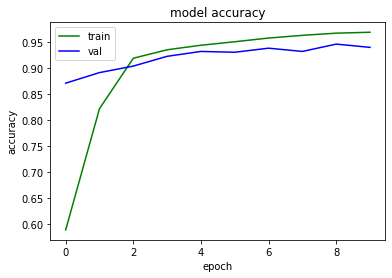

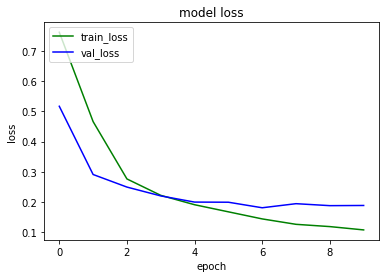

In [6]:
print(history.history.keys())       

plt.plot(history.history['accuracy'],'g')         ##plotting training_accuracy,val_accuracy againist no of epochs    
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()    ##displays the figure


plt.plot(history.history['loss'],'g')             ##plotting training_loss,val_loss againist no of epochs    
plt.plot(history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'],loc='upper left')
plt.show()



In [7]:
Right_pred=0
prediction = model.predict(X_test)

for i in tqdm(range(0,len(X_test))):
  class_id=np.argmax(prediction[i])
  label_id=np.argmax(Y_test[i])
  if class_id==label_id:
    Right_pred=Right_pred+1

overall_test_acc=Right_pred/len(X_test)
print('/n')
print("TEST_ACCURACY: ")
print(overall_test_acc)



100%|██████████| 624/624 [00:00<00:00, 68690.51it/s]

/n
TEST_ACCURACY: 
0.9375
